# PART II

## Fine-tuning BERT

In [1]:
from transformers import BertForSequenceClassification, BertTokenizer, Trainer, TrainingArguments, \
BertForQuestionAnswering, DistilBertForTokenClassification, AutoTokenizer, AutoModel, AutoModelForTokenClassification, \
pipeline, DataCollatorWithPadding

from datasets import Dataset
import torch
import numpy as np
import pandas as pd

import re

# for visualizations
import seaborn as sns
import matplotlib.pyplot as plt

/Users/loaynasser/miniconda3/envs/tensorflow/lib/python3.10/site-packages/requests/__init__.py:109: RequestsDependencyWarning: urllib3 (1.26.15) or chardet (None)/charset_normalizer (3.1.0) doesn't match a supported version!
  warnings.warn(


# Quick Examples using the pipeline object in transformers

We can run some quick examples of fine-tuned models using the nlp module in the transformers package

In [2]:
# list of available pipelines here: https://huggingface.co/transformers/main_classes/pipelines.html
nlp = pipeline("question-answering")

print(type(nlp.model))  # Using a flavor of BERT called DistilBERT

No model was supplied, defaulted to distilbert-base-cased-distilled-squad (https://huggingface.co/distilbert-base-cased-distilled-squad)


Downloading:   0%|          | 0.00/473 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/249M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

<class 'transformers.models.distilbert.modeling_distilbert.DistilBertForQuestionAnswering'>


In [3]:
context = "My friend Georg owns a bird. I, Loay, own a dog. Max just got a cat!"

print(nlp(question="What kind of pet does Loay have?", context=context))  # should be dog
print(nlp(question="What kind of pet does Max have?", context=context))  # should be cat
print(nlp(question="What kind of pet does Georg have?", context=context))  # should be bird

{'score': 0.8341888785362244, 'start': 45, 'end': 48, 'answer': 'dog'}
{'score': 0.7366523146629333, 'start': 65, 'end': 68, 'answer': 'cat'}
{'score': 0.29512688517570496, 'start': 45, 'end': 48, 'answer': 'dog'}


In [4]:
# A sentiment analysis pipeline
nlp = pipeline("sentiment-analysis")

print(type(nlp.model))  # Using a flavor of BERT called DistilBERT

print(nlp("My friend told me about this class and I love it so far! She was right."))

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english)


Downloading:   0%|          | 0.00/629 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/255M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

<class 'transformers.models.distilbert.modeling_distilbert.DistilBertForSequenceClassification'>
[{'label': 'POSITIVE', 'score': 0.9998711347579956}]


In [5]:
# We can even do a auto-encoder language model task!

nlp = pipeline("fill-mask")

print(type(nlp.model))  # Using a flavor of BERT called RoBERTa

preds = nlp(f"If you don’t {nlp.tokenizer.mask_token} at the sign, you will get a ticket")
print('If you don’t *** at the sign, you will get a ticket')
for p in preds:
    print(f"Token:{p['token_str']}. Score: {100*p['score']:,.2f}%")

No model was supplied, defaulted to distilroberta-base (https://huggingface.co/distilroberta-base)


Downloading:   0%|          | 0.00/480 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/316M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

<class 'transformers.models.roberta.modeling_roberta.RobertaForMaskedLM'>
If you don’t *** at the sign, you will get a ticket
Token: stop. Score: 42.11%
Token: look. Score: 7.53%
Token: park. Score: 4.92%
Token: arrive. Score: 4.65%
Token: sign. Score: 4.27%


# Example 1: Sequence Classification

![BERT Sequence Classification](images/bert_seq_class.png)

In [6]:
# Ingest 100 tweets from the Kaggle disaster tweet comopetition

tweets = pd.read_csv('./data/disaster_sample.csv')

print(tweets.shape)

tweets.head(2)

(200, 7)


index     id  keyword   location  \
0   7138  10224  volcano        NaN   
1   2151   3086   deaths  Blackpool   

                                                text  target  label  
0  @MrMikeEaton @Muazimus_Prime hill hill mountai...       1      1  
1  Cancers equate for around 25% of all deaths in...       1      1

In [7]:
BERT_MODEL = 'bert-large-uncased'

In [8]:
# check our tokenizer

tokenizer = BertTokenizer.from_pretrained(BERT_MODEL)

first_tweet = tweets['text'][0]

tokens = tokenizer.encode(first_tweet)

print(f'Tweet: {first_tweet}. Num tokens: {len(tokens)}')
for t in tokens:
    print(f'Token: {t}, subword: {tokenizer.decode([t])}')

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/571 [00:00<?, ?B/s]

Tweet: @MrMikeEaton @Muazimus_Prime hill hill mountain volcano of hell mountain hill hil.. Num tokens: 24
Token: 101, subword: [CLS]
Token: 1030, subword: @
Token: 2720, subword: mr
Token: 4328, subword: ##mi
Token: 20553, subword: ##kee
Token: 22436, subword: ##aton
Token: 1030, subword: @
Token: 14163, subword: mu
Token: 16103, subword: ##azi
Token: 7606, subword: ##mus
Token: 1035, subword: _
Token: 3539, subword: prime
Token: 2940, subword: hill
Token: 2940, subword: hill
Token: 3137, subword: mountain
Token: 12779, subword: volcano
Token: 1997, subword: of
Token: 3109, subword: hell
Token: 3137, subword: mountain
Token: 2940, subword: hill
Token: 7632, subword: hi
Token: 2140, subword: ##l
Token: 1012, subword: .
Token: 102, subword: [SEP]


## Exploratory Data Analysis

In [9]:
tweets['target'].value_counts()

0    114
1     86
Name: target, dtype: int64

In [10]:
# the trainer is expecting a 'label' (see the forward method in the docs)
tweets['label'] = tweets['target']

tweets['label'].value_counts()

0    114
1     86
Name: label, dtype: int64

In [13]:
tweet_dataset = Dataset.from_pandas(tweets)

In [11]:
type(tweet_dataset)

datasets.arrow_dataset.Dataset

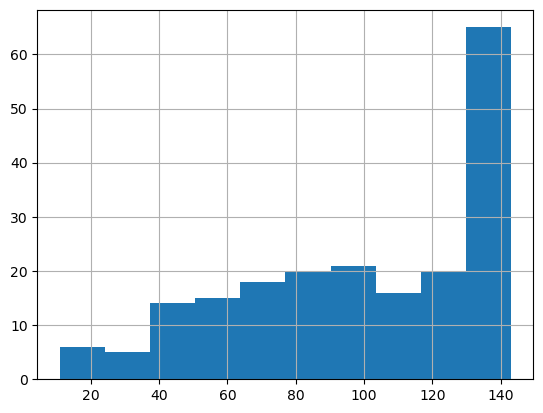

In [13]:
# Histogram of tweet lengths after cleaning. Not very normal

tweets['text'].apply(len).hist()

## Data Preprocessing and Cleaning

In [15]:
URL_REGEX = re.compile('http(s)?:\/\/t.co\/\w+')
MENTION_REGEX = re.compile('@\s?\w+')

def clean_tweet(tweet):
    # remove mentions, the pound sign, and replace urls with URL token
    tweet = re.sub(URL_REGEX, 'url', tweet)  # replace urls with url. Assumes that the mention of a url is significant
    tweet = re.sub(MENTION_REGEX, '', tweet)  # remove mentions entirely
    tweet = tweet.replace('#', '')  # remove pound signs
    
    return tweet.strip()

clean_tweet('@prof_oz MEG issues Hazardous #Weather Outlook (HWO) http://t.co/3X6RBQJHn3')


'MEG issues Hazardous Weather Outlook (HWO) url'

In [16]:
tweets['text'] = tweets['text'].apply(clean_tweet)

<Axes: >

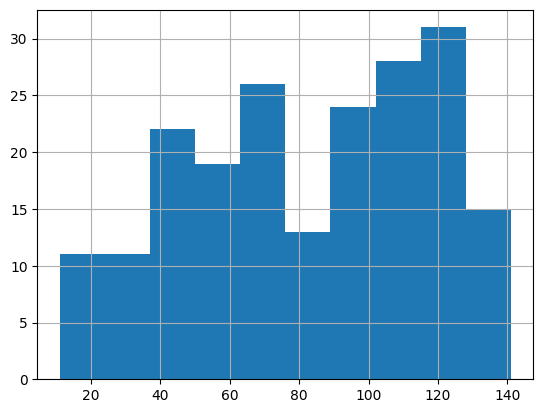

In [17]:
# Histogram of tweet lengths after cleaning. Much more normal :)

tweets['text'].apply(len).hist()

In [17]:
tweet_dataset

Dataset({
    features: ['index', 'id', 'keyword', 'location', 'text', 'target', 'label'],
    num_rows: 200
})

In [18]:
tweets

index     id              keyword                  location  \
0     7138  10224              volcano                       NaN   
1     2151   3086               deaths                 Blackpool   
2     4395   6247            hijacking                     World   
3     2508   3602           desolation            Birmingham, UK   
4     1378   1987         bush%20fires  London/Bristol/Guildford   
..     ...    ...                  ...                       ...   
195   4522   6425            hurricane                       NaN   
196   2049   2941               danger    Instagram: trillrebel_   
197   7532  10770             wreckage                    iTunes   
198   5345   7630          pandemonium   illinois. united state    
199   1342   1940  burning%20buildings                       NaN   

                                                  text  target  label  
0    hill hill mountain volcano of hell mountain hi...       1      1  
1    Cancers equate for around 25% of all deaths in...       1      1  
2    The Murderous Story Of AmericaÛªs First Hijac...       1      1  
3    The date for the release of EP03 DESOLATION is...       1      1  
4    On holiday to relax sunbathe and drink ... Put...       0      0  
..                                                 ...     ...    ...  
195                              Stream HYPE HURRICANE       0      0  
196  Guns are for protection.. \nThat shit really s...       0      0  
197  science Now that a piece of wreckage from flig...       1      1  
198  Pandemonium In Aba As Woman Delivers Baby With...       0      0  
199  Hero's fight wars and save ppl from burning bu...       0      0  

[200 rows x 7 columns]

In [19]:
tokenizer('hey there')

{'input_ids': [101, 4931, 2045, 102], 'token_type_ids': [0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1]}

In [18]:
# We will not pad our dataset so we can do it dynamically to speed up training
def preprocess(data):
    return tokenizer(data['text'], truncation=True)

tweet_dataset = tweet_dataset.map(
    preprocess, 
    batched=True, 
    batch_size=len(tweet_dataset),
    remove_columns=['index', 'id', 'keyword', 'location', 'text', 'target']
)
tweet_dataset[0]

Parameter 'function'=<function preprocess at 0x2ce975b40> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


  0%|          | 0/1 [00:00<?, ?ba/s]

{'attention_mask': [1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1],
 'input_ids': [101,
  1030,
  2720,
  4328,
  20553,
  22436,
  1030,
  14163,
  16103,
  7606,
  1035,
  3539,
  2940,
  2940,
  3137,
  12779,
  1997,
  3109,
  3137,
  2940,
  7632,
  2140,
  1012,
  102],
 'label': 1,
 'token_type_ids': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0]}

In [21]:
tweet_dataset

Dataset({
    features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 200
})

In [19]:
# Dataset has a built in train test split method
tweet_dataset = tweet_dataset.train_test_split(test_size=0.2)

In [20]:
len(tweet_dataset['train']), len(tweet_dataset['test'])

(160, 40)

## Building Classification Model

In [21]:
# using an uncased model means I am assuming that case will not matter when predicting our categories
sequence_classification_model = BertForSequenceClassification.from_pretrained(
    BERT_MODEL, num_labels=2,
    output_attentions=False,
    output_hidden_states=False
)

sequence_classification_model.config.id2label = {0: 'NOT DISASTER', 1: 'DISASTER'}


Downloading:   0%|          | 0.00/1.25G [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint a

Let's break down this warning:

```
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']


- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
```

This is telling us about the weights that it is not using in this sequence classification version of BERT

--

```
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
```

The `classifier.weight` and `classifier.bias` are two new matrices we need to learn during fine-tuning

In [22]:
type(sequence_classification_model.bert)  # normal BERT model

transformers.models.bert.modeling_bert.BertModel

In [23]:
sequence_classification_model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 1024, padding_idx=0)
      (position_embeddings): Embedding(512, 1024)
      (token_type_embeddings): Embedding(2, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((1024,), eps=1

In [24]:
# this classifier is a feed forward layer that is shared across tokens. It squashes the BERT's 768 dimension
# into 2 dimensions (disaster or not disaster)
print(sequence_classification_model.classifier.weight.shape)

print(sequence_classification_model.classifier.bias.shape)

torch.Size([2, 1024])
torch.Size([2])


In [25]:
tokenizer = BertTokenizer.from_pretrained(BERT_MODEL)


In [26]:
tweet = tweets['text'][0]
print(tweet)

token_ids = torch.tensor(tokenizer.encode(tweet)).unsqueeze(0)

pre_finetuning_response = sequence_classification_model(
    token_ids, output_hidden_states=True
)

pre_finetuning_response.hidden_states[0]

hill hill mountain volcano of hell mountain hill hil.


tensor([[[-0.0757, -0.2677, -0.2437,  ..., -0.1609, -0.2434,  0.0849],
         [ 0.3218, -0.8701, -1.0655,  ..., -0.5041,  0.7683,  0.6173],
         [ 0.1904, -1.1727, -0.6511,  ..., -0.5110,  1.0933,  0.8200],
         ...,
         [-1.0475,  0.3265, -0.4232,  ...,  0.4013,  0.5853,  0.0258],
         [ 0.0767,  0.0371, -0.1873,  ...,  0.4422,  0.4291,  0.4383],
         [-0.2622,  0.2595, -0.3092,  ..., -0.1652,  0.3450,  0.2026]]],
       grad_fn=<NativeLayerNormBackward0>)

In [28]:
pre_finetuning_response.logits

tensor([[-0.1542,  0.2499]], grad_fn=<AddmmBackward0>)

In [29]:
# DataCollatorWithPadding creates batch of data. It also dynamically pads text to the 
#  length of the longest element in the batch, making them all the same length. 
#  It's possible to pad your text in the tokenizer function with padding=True, dynamic padding is more efficient.
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [ ]:
# DataCollator is a term commonly used in the field of machine learning and natural language processing (NLP). 
# It refers to a component or class that is responsible for collating and preparing data for training or 
# evaluation in a machine learning model.
# In the context of NLP, data collation involves combining and organizing textual data in a suitable format 
# that can be processed by a language model or other NLP algorithms. 
# This process often includes tasks such as tokenization, batching, padding, and masking.
# The DataCollator class or component typically provides methods or functionalities to handle these data preparation tasks.
# It takes a dataset, which could be a collection of text examples or data samples, 
# and processes them into input tensors or batches that can be fed into a machine learning model for training or evaluation.
# The specific operations performed by a DataCollator can vary depending on the requirements of the model 
# and the particular task at hand. For example, in sequence classification tasks, 
# the DataCollator might convert a list of text samples into tokenized inputs with attention masks and labels. 
# In machine translation tasks, it may handle the collation of parallel source and target language sentences.
# Overall, the DataCollator plays an essential role in simplifying and automating the data preparation 
# pipeline for training or evaluating machine learning models, especially in the domain of NLP.

In [30]:
batch = data_collator(tweet_dataset['train'][:2])

batch

{'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'input_ids': tensor([[  101,  2106,  3312,  2271,  2131,  2009,  3308,  2055, 19078,  2271,
          4958, 11514, 28006,  2015,  1998,  1996, 11113, 20936,  9323,  1997,
          4078,  6030,  3508,  1029,  3191,  2062,  1024,  8299,  1024,  1013,
          1013,  1056,  1012,  2522,  1013,  1042,  2860,  3501,  2683,  9468,
          2100,  2860,  2575,  2243,   102],
        [  101,  2750,  1996, 13675, 11514, 14353, 10089,  1998, 10827,  6634,
          4491,  1045,  1005,  1040,  2360,  1045,  1005,  1049,  7199,  2092,
          1011, 10426,  1012,   102,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,   

In [31]:
batch['input_ids']

tensor([[  101,  2106,  3312,  2271,  2131,  2009,  3308,  2055, 19078,  2271,
          4958, 11514, 28006,  2015,  1998,  1996, 11113, 20936,  9323,  1997,
          4078,  6030,  3508,  1029,  3191,  2062,  1024,  8299,  1024,  1013,
          1013,  1056,  1012,  2522,  1013,  1042,  2860,  3501,  2683,  9468,
          2100,  2860,  2575,  2243,   102],
        [  101,  2750,  1996, 13675, 11514, 14353, 10089,  1998, 10827,  6634,
          4491,  1045,  1005,  1040,  2360,  1045,  1005,  1049,  7199,  2092,
          1011, 10426,  1012,   102,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0]])

In [32]:
tokenizer.pad_token_id

0

In [33]:
batch['attention_mask']

tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [34]:
batch['token_type_ids']

tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [37]:
batch['labels']

tensor([0, 0])

In [38]:
tokenizer.decode(batch['input_ids'][1])  # see the pad tokens. 0 --> [PAD]

"[CLS] despite the crippling anxiety and overwhelming panic attacks i'd say i'm fairly well - adjusted. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]"

In [39]:
batch_size = 8  # how many examples to train on every batch
epochs = 4  # how times to go over the entire dataset


training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=epochs,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    logging_dir='./logs',
    logging_strategy='epoch',
    evaluation_strategy='epoch',
    save_strategy='epoch',
    load_best_model_at_end=True,
    logging_steps=1
)

# Define accuracy metric:

from datasets import load_metric

metric = load_metric("accuracy")

def compute_metrics(eval_pred):  # custom method to take in logits and calculate accuracy of the eval set
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

# Define the trainer:

trainer = Trainer(
    model=sequence_classification_model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=tweet_dataset['train'],
    eval_dataset=tweet_dataset['test'],
    compute_metrics=compute_metrics
)

Downloading:   0%|          | 0.00/1.42k [00:00<?, ?B/s]

In [40]:
# Get initial metrics including accuracy
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 40
  Batch size = 8


  0%|          | 0/5 [00:00<?, ?it/s]

{'eval_loss': 0.7358219027519226,
 'eval_accuracy': 0.4,
 'eval_runtime': 2.0535,
 'eval_samples_per_second': 19.479,
 'eval_steps_per_second': 2.435}

In [41]:
trainer.train()  # Train our model!!

/Users/loaynasser/miniconda3/envs/tensorflow/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 160
  Num Epochs = 4
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 80


  0%|          | 0/80 [00:00<?, ?it/s]

***** Running Evaluation *****
  Num examples = 40
  Batch size = 8


{'loss': 0.6748, 'learning_rate': 3.7500000000000003e-05, 'epoch': 1.0}


  0%|          | 0/5 [00:00<?, ?it/s]

Saving model checkpoint to ./results/checkpoint-20
Configuration saved in ./results/checkpoint-20/config.json


{'eval_loss': 0.5239974856376648, 'eval_accuracy': 0.825, 'eval_runtime': 2.083, 'eval_samples_per_second': 19.203, 'eval_steps_per_second': 2.4, 'epoch': 1.0}


Model weights saved in ./results/checkpoint-20/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 40
  Batch size = 8


{'loss': 0.4873, 'learning_rate': 2.5e-05, 'epoch': 2.0}


  0%|          | 0/5 [00:00<?, ?it/s]

Saving model checkpoint to ./results/checkpoint-40
Configuration saved in ./results/checkpoint-40/config.json


{'eval_loss': 0.48909991979599, 'eval_accuracy': 0.775, 'eval_runtime': 1.8796, 'eval_samples_per_second': 21.281, 'eval_steps_per_second': 2.66, 'epoch': 2.0}


Model weights saved in ./results/checkpoint-40/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 40
  Batch size = 8


{'loss': 0.2523, 'learning_rate': 1.25e-05, 'epoch': 3.0}


  0%|          | 0/5 [00:00<?, ?it/s]

Saving model checkpoint to ./results/checkpoint-60
Configuration saved in ./results/checkpoint-60/config.json


{'eval_loss': 0.7170237302780151, 'eval_accuracy': 0.75, 'eval_runtime': 1.991, 'eval_samples_per_second': 20.09, 'eval_steps_per_second': 2.511, 'epoch': 3.0}


Model weights saved in ./results/checkpoint-60/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 40
  Batch size = 8


{'loss': 0.0977, 'learning_rate': 0.0, 'epoch': 4.0}


  0%|          | 0/5 [00:00<?, ?it/s]

Saving model checkpoint to ./results/checkpoint-80
Configuration saved in ./results/checkpoint-80/config.json


{'eval_loss': 0.8797991871833801, 'eval_accuracy': 0.775, 'eval_runtime': 1.9721, 'eval_samples_per_second': 20.283, 'eval_steps_per_second': 2.535, 'epoch': 4.0}


Model weights saved in ./results/checkpoint-80/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./results/checkpoint-40 (score: 0.48909991979599).


{'train_runtime': 224.6468, 'train_samples_per_second': 2.849, 'train_steps_per_second': 0.356, 'train_loss': 0.37802883684635163, 'epoch': 4.0}


TrainOutput(global_step=80, training_loss=0.37802883684635163, metrics={'train_runtime': 224.6468, 'train_samples_per_second': 2.849, 'train_steps_per_second': 0.356, 'train_loss': 0.37802883684635163, 'epoch': 4.0})

In [42]:
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 40
  Batch size = 8


  0%|          | 0/5 [00:00<?, ?it/s]

{'eval_loss': 0.48909991979599,
 'eval_accuracy': 0.775,
 'eval_runtime': 2.0108,
 'eval_samples_per_second': 19.892,
 'eval_steps_per_second': 2.487,
 'epoch': 4.0}

In [43]:
print(tweet)

post_finetuning_response = sequence_classification_model(
    token_ids, output_hidden_states=True
)

# hidden states are different from before fine tuning
(post_finetuning_response.hidden_states[0] == pre_finetuning_response.hidden_states[0]).all()

hill hill mountain volcano of hell mountain hill hil.


tensor(False)

In [44]:
post_finetuning_response.hidden_states[0]

tensor([[[-0.0718, -0.2613, -0.2364,  ..., -0.1636, -0.2472,  0.0844],
         [ 0.3250, -0.8769, -1.0524,  ..., -0.5131,  0.7536,  0.6169],
         [ 0.1909, -1.1704, -0.6398,  ..., -0.5164,  1.0803,  0.8180],
         ...,
         [-1.0339,  0.3278, -0.4195,  ...,  0.3895,  0.5809,  0.0329],
         [ 0.0794,  0.0351, -0.1803,  ...,  0.4284,  0.4176,  0.4377],
         [-0.2530,  0.2707, -0.3032,  ..., -0.1758,  0.3360,  0.1949]]],
       grad_fn=<NativeLayerNormBackward0>)

In [45]:
post_finetuning_response.logits

tensor([[ 0.2372, -0.0774]], grad_fn=<AddmmBackward0>)

In [46]:
trainer.save_model()

Saving model checkpoint to ./results
Configuration saved in ./results/config.json
Model weights saved in ./results/pytorch_model.bin


In [47]:
# make a classification pipeline
pipe = pipeline("text-classification", './results', tokenizer=BERT_MODEL)

loading configuration file ./results/config.json
Model config BertConfig {
  "_name_or_path": "./results",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 1024,
  "id2label": {
    "0": "NOT DISASTER",
    "1": "DISASTER"
  },
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "label2id": null,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 16,
  "num_hidden_layers": 24,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "float32",
  "transformers_version": "4.16.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading configuration file ./results/config.json
Model config BertConfig {
  "_name_or_path": "./results",
  "architectu

In [48]:
pipe('Such a terrible earthquake')

[{'label': 'NOT DISASTER', 'score': 0.8111319541931152}]

Let's try that sequence again but this time, let's freeze the layers of BERT to try and speed up training

In [49]:
# re-instantiate BERT
new_sequence_classification_model = BertForSequenceClassification.from_pretrained(
    BERT_MODEL, num_labels=2,
    output_attentions=False,
    output_hidden_states=False
)


loading configuration file https://huggingface.co/bert-large-uncased/resolve/main/config.json from cache at /Users/loaynasser/.cache/huggingface/transformers/1cf090f220f9674b67b3434decfe4d40a6532d7849653eac435ff94d31a4904c.1d03e5e4fa2db2532c517b2cd98290d8444b237619bd3d2039850a6d5e86473d
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 1024,
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 16,
  "num_hidden_layers": 24,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.16.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file https://huggingface.co/bert-large-uncased/resolve/main/pytorch_model.

In [50]:
# freeze all layers in BERT to speed up training
for name, param in new_sequence_classification_model.bert.named_parameters():
    param.requires_grad = False  # disable training in BERT

In [51]:
# Change the model in the trainer to be our newly instantiated model

trainer = Trainer(
    model=new_sequence_classification_model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=tweet_dataset['train'],
    eval_dataset=tweet_dataset['test'],
    compute_metrics=compute_metrics
)

# Get initial metrics. Similar as before. Check: Why isn't it the same loss?
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 40
  Batch size = 8


  0%|          | 0/5 [00:00<?, ?it/s]

{'eval_loss': 0.8661748170852661,
 'eval_accuracy': 0.575,
 'eval_runtime': 1.9398,
 'eval_samples_per_second': 20.62,
 'eval_steps_per_second': 2.578}

In [52]:
trainer.train()  # MUCH faster training time but training did not go as well!

/Users/loaynasser/miniconda3/envs/tensorflow/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 160
  Num Epochs = 4
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 80


  0%|          | 0/80 [00:00<?, ?it/s]

***** Running Evaluation *****
  Num examples = 40
  Batch size = 8


{'loss': 0.7933, 'learning_rate': 3.7500000000000003e-05, 'epoch': 1.0}


  0%|          | 0/5 [00:00<?, ?it/s]

Saving model checkpoint to ./results/checkpoint-20
Configuration saved in ./results/checkpoint-20/config.json


{'eval_loss': 0.680439293384552, 'eval_accuracy': 0.575, 'eval_runtime': 1.8969, 'eval_samples_per_second': 21.087, 'eval_steps_per_second': 2.636, 'epoch': 1.0}


Model weights saved in ./results/checkpoint-20/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 40
  Batch size = 8


{'loss': 0.717, 'learning_rate': 2.5e-05, 'epoch': 2.0}


  0%|          | 0/5 [00:00<?, ?it/s]

Saving model checkpoint to ./results/checkpoint-40
Configuration saved in ./results/checkpoint-40/config.json


{'eval_loss': 0.6741424798965454, 'eval_accuracy': 0.6, 'eval_runtime': 2.1563, 'eval_samples_per_second': 18.551, 'eval_steps_per_second': 2.319, 'epoch': 2.0}


Model weights saved in ./results/checkpoint-40/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 40
  Batch size = 8


{'loss': 0.7068, 'learning_rate': 1.25e-05, 'epoch': 3.0}


  0%|          | 0/5 [00:00<?, ?it/s]

Saving model checkpoint to ./results/checkpoint-60
Configuration saved in ./results/checkpoint-60/config.json


{'eval_loss': 0.6739400029182434, 'eval_accuracy': 0.575, 'eval_runtime': 2.1124, 'eval_samples_per_second': 18.936, 'eval_steps_per_second': 2.367, 'epoch': 3.0}


Model weights saved in ./results/checkpoint-60/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 40
  Batch size = 8


{'loss': 0.692, 'learning_rate': 0.0, 'epoch': 4.0}


  0%|          | 0/5 [00:00<?, ?it/s]

Saving model checkpoint to ./results/checkpoint-80
Configuration saved in ./results/checkpoint-80/config.json


{'eval_loss': 0.6741493940353394, 'eval_accuracy': 0.575, 'eval_runtime': 2.0166, 'eval_samples_per_second': 19.835, 'eval_steps_per_second': 2.479, 'epoch': 4.0}


Model weights saved in ./results/checkpoint-80/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./results/checkpoint-60 (score: 0.6739400029182434).


{'train_runtime': 57.5224, 'train_samples_per_second': 11.126, 'train_steps_per_second': 1.391, 'train_loss': 0.7272643327713013, 'epoch': 4.0}


TrainOutput(global_step=80, training_loss=0.7272643327713013, metrics={'train_runtime': 57.5224, 'train_samples_per_second': 11.126, 'train_steps_per_second': 1.391, 'train_loss': 0.7272643327713013, 'epoch': 4.0})

In [55]:
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 40
  Batch size = 8


  0%|          | 0/5 [00:00<?, ?it/s]

{'eval_loss': 0.6739400029182434,
 'eval_accuracy': 0.575,
 'eval_runtime': 2.0477,
 'eval_samples_per_second': 19.534,
 'eval_steps_per_second': 2.442,
 'epoch': 4.0}

In [53]:
post_finetuning_response = new_sequence_classification_model(
    token_ids, output_hidden_states=True
)

# hidden states are same as before fine tuning
(post_finetuning_response.hidden_states[0] == pre_finetuning_response.hidden_states[0]).all()

tensor(True)

In [54]:
# the logits are different as the pre-trained model because the classifier weights are initialized randomly every time
#  this is also why the initial logits weren't the same

pre_finetuning_response.logits, post_finetuning_response.logits  

(tensor([[-0.1542,  0.2499]], grad_fn=<AddmmBackward0>),
 tensor([[ 0.0941, -0.0979]], grad_fn=<AddmmBackward0>))

# BONUS Material
## Example 2. Question/Answering with a model already fine-tuned using SQuAD


![BERT QA](images/bert_qa.png)

In [56]:
# there are pre fine-tuned models that learned from the SQuAD dataset

large_bert_tokenizer = BertTokenizer.from_pretrained('bert-large-uncased', return_token_type_ids=True)
qa_bert = BertForQuestionAnswering.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')

loading file vocab.txt from cache at /Users/sinanozdemir/.cache/huggingface/hub/models--bert-large-uncased/snapshots/80792f8e8216b29f3c846b653a0ff0a37c210431/vocab.txt
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at /Users/sinanozdemir/.cache/huggingface/hub/models--bert-large-uncased/snapshots/80792f8e8216b29f3c846b653a0ff0a37c210431/tokenizer_config.json
loading configuration file config.json from cache at /Users/sinanozdemir/.cache/huggingface/hub/models--bert-large-uncased/snapshots/80792f8e8216b29f3c846b653a0ff0a37c210431/config.json
Model config BertConfig {
  "_name_or_path": "bert-large-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 1024,
  "initializer_range": 0.02,
  "intermediate_size": 

In [57]:
type(qa_bert.bert)  # BERT model

transformers.models.bert.modeling_bert.BertModel

In [58]:
print(f'number of layers in the encoder stack: {len(qa_bert.bert.encoder.layer)}')  #  LARGE BERT

number of layers in the encoder stack: 24


### Count the Parameters in Large BERT

In [59]:
total_params = 0
for p in qa_bert.bert.parameters():
    if len(p.shape) == 2:
        total_params += p.shape[0] * p.shape[1]
        
print(f'Total Parameters: {total_params:,}')  # This is where the 110M parameter comes from

Total Parameters: 333,770,752


In [60]:
# Get all of the model's parameters as a list of tuples.
params = list(qa_bert.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-2:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))


The BERT model has 391 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 1024)
bert.embeddings.position_embeddings.weight               (512, 1024)
bert.embeddings.token_type_embeddings.weight               (2, 1024)
bert.embeddings.LayerNorm.weight                             (1024,)
bert.embeddings.LayerNorm.bias                               (1024,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight        (1024, 1024)
bert.encoder.layer.0.attention.self.query.bias               (1024,)
bert.encoder.layer.0.attention.self.key.weight          (1024, 1024)
bert.encoder.layer.0.attention.self.key.bias                 (1024,)
bert.encoder.layer.0.attention.self.value.weight        (1024, 1024)
bert.encoder.layer.0.attention.self.value.bias               (1024,)
bert.encoder.layer.0.attention.output.dense.weight      (1024, 1024)
bert.encoder.layer.0.attention.output.dense.bias             (

In [61]:
# this qa_outputs is a feed forward layer that is shared across tokens. It squashes the BERT-large's 1024 dimension
# into 2 dimensions (start position and end position)

In [62]:
sns.set(rc={"figure.figsize":(20, 5)}) 

def q_a(question, context):
    encodings = large_bert_tokenizer.encode_plus(question, context)

    inputIds, attentionMask = encodings["input_ids"], encodings["attention_mask"]

    response = qa_bert(torch.tensor([inputIds]), attention_mask=torch.tensor([attentionMask]))
    scoresStart, scoresEnd = response['start_logits'], response['end_logits']
    tokens = inputIds[torch.argmax(scoresStart): torch.argmax(scoresEnd) + 1]
    answerTokens = large_bert_tokenizer.convert_ids_to_tokens(tokens, skip_special_tokens=True)
    
    token_labels = large_bert_tokenizer.convert_ids_to_tokens(inputIds)
    
    
    # bar plot code courtesy of Chris McCormick
    # https://mccormickml.com/2020/03/10/question-answering-with-a-fine-tuned-BERT
    
    # Create a barplot showing the start word score for all of the tokens.
    ax = sns.barplot(x=[f'{i}_{t}' for i, t in enumerate(token_labels)], y=scoresStart.squeeze().tolist(), ci=None)
    # Turn the xlabels vertical.
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
    # Turn on the vertical grid to help align words to scores.
    plt.title('Start Word Scores')
    
    plt.show()
    
    # Create a barplot showing the start word score for all of the tokens.
    ax = sns.barplot(x=[f'{i}_{t}' for i, t in enumerate(token_labels)], y=scoresEnd.squeeze().tolist(), ci=None)
    # Turn the xlabels vertical.
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
    # Turn on thaae vertical grid to help align words to scores.
    plt.title('End Word Scores')

    plt.show()
    
    return large_bert_tokenizer.convert_tokens_to_string(answerTokens)

In [63]:
q_a("Where does Matt live?", "Matt lives in Canada and Sinan lives in California")

/var/folders/y9/9xqbqkg90tnc0cmm0dxt985m0000gn/T/ipykernel_26907/2807390656.py:20: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(x=[f'{i}_{t}' for i, t in enumerate(token_labels)], y=scoresStart.squeeze().tolist(), ci=None)


/var/folders/y9/9xqbqkg90tnc0cmm0dxt985m0000gn/T/ipykernel_26907/2807390656.py:29: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(x=[f'{i}_{t}' for i, t in enumerate(token_labels)], y=scoresEnd.squeeze().tolist(), ci=None)


'canada'

In [64]:
# From https://docs.microsoft.com/en-us/azure/databricks/kb/jobs/active-vs-dead-jobs

longer_context = """
Whenever there are too many concurrent jobs running on a cluster, there is a chance that the Spark internal 
eventListenerBus drops events. These events are used to track job progress in the Spark UI. Whenever the event 
listener drops events you start seeing dead jobs/stages in Spark UI, which never finish. 
The jobs are actually finished but not shown as completed in the Spark UI.
"""

In [65]:
print(len(tokenizer(longer_context)['input_ids']))  # 78 tokens
      
for t in tokenizer(longer_context)['input_ids'][:30]:
    print(f'Token: {t}, subword: {tokenizer.decode([t])}')
    


78
Token: 101, subword: [CLS]
Token: 7188, subword: whenever
Token: 2045, subword: there
Token: 2024, subword: are
Token: 2205, subword: too
Token: 2116, subword: many
Token: 16483, subword: concurrent
Token: 5841, subword: jobs
Token: 2770, subword: running
Token: 2006, subword: on
Token: 1037, subword: a
Token: 9324, subword: cluster
Token: 1010, subword: ,
Token: 2045, subword: there
Token: 2003, subword: is
Token: 1037, subword: a
Token: 3382, subword: chance
Token: 2008, subword: that
Token: 1996, subword: the
Token: 12125, subword: spark
Token: 4722, subword: internal
Token: 2724, subword: event
Token: 9863, subword: ##list
Token: 24454, subword: ##ener
Token: 8286, subword: ##bus
Token: 9010, subword: drops
Token: 2824, subword: events
Token: 1012, subword: .
Token: 2122, subword: these
Token: 2824, subword: events


/var/folders/y9/9xqbqkg90tnc0cmm0dxt985m0000gn/T/ipykernel_26907/2807390656.py:20: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(x=[f'{i}_{t}' for i, t in enumerate(token_labels)], y=scoresStart.squeeze().tolist(), ci=None)


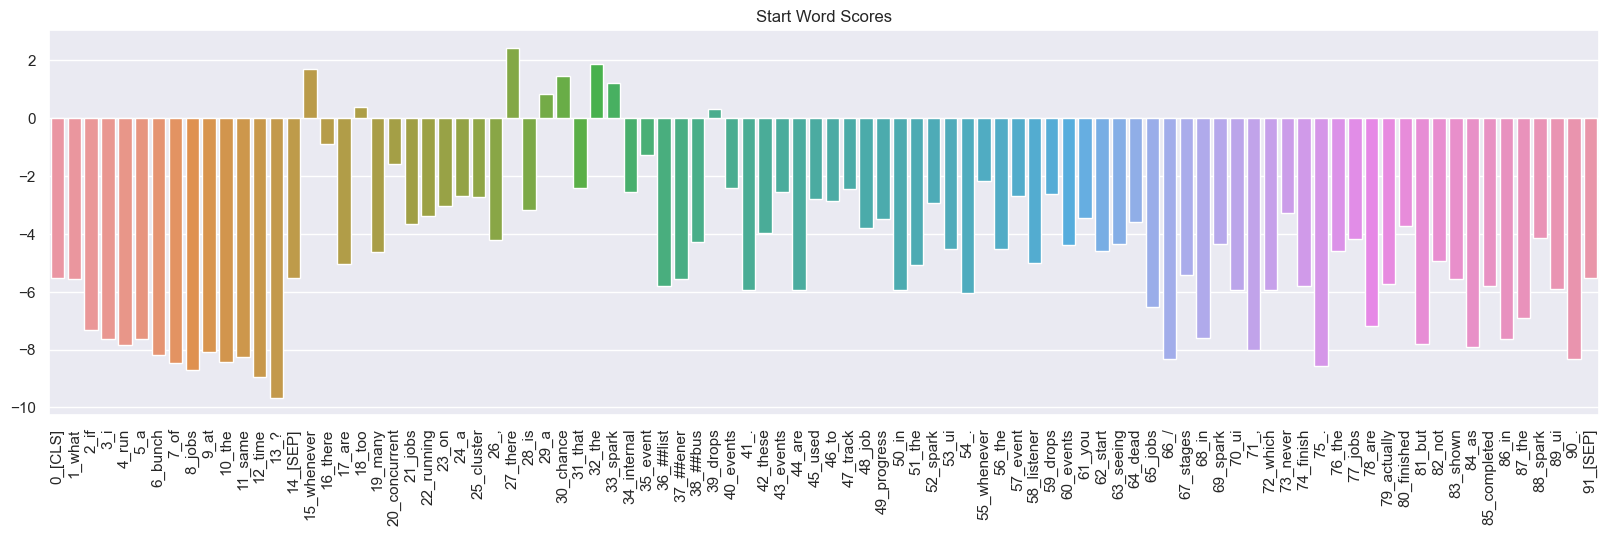

/var/folders/y9/9xqbqkg90tnc0cmm0dxt985m0000gn/T/ipykernel_26907/2807390656.py:29: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(x=[f'{i}_{t}' for i, t in enumerate(token_labels)], y=scoresEnd.squeeze().tolist(), ci=None)


'there is a chance that the spark internal eventlistenerbus drops events'

In [66]:
q_a("what if I run a bunch of jobs at the same time?", longer_context)

# Working with flavors of BERT

In [67]:
distil_model = DistilBertForTokenClassification.from_pretrained('distilbert-base-uncased')


loading configuration file config.json from cache at /Users/sinanozdemir/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/config.json
Model config DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.23.1",
  "vocab_size": 30522
}

loading weights file pytorch_model.bin from cache at /Users/sinanozdemir/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/pytorch_model.bin
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilB

In [68]:
type(distil_model)

transformers.models.distilbert.modeling_distilbert.DistilBertForTokenClassification

In [69]:
# Get all of the model's parameters as a list of tuples.
named_params = list(distil_model.named_parameters())

print('The DistilBERT model has {:} different named parameters.\n'.format(len(named_params)))

print('==== Embedding Layer ====\n')
for p in named_params[0:4]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')
for p in named_params[5:20]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')
for p in named_params[-2:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))


The DistilBERT model has 102 different named parameters.

==== Embedding Layer ====

distilbert.embeddings.word_embeddings.weight            (30522, 768)
distilbert.embeddings.position_embeddings.weight          (512, 768)
distilbert.embeddings.LayerNorm.weight                        (768,)
distilbert.embeddings.LayerNorm.bias                          (768,)

==== First Transformer ====

distilbert.transformer.layer.0.attention.q_lin.bias           (768,)
distilbert.transformer.layer.0.attention.k_lin.weight     (768, 768)
distilbert.transformer.layer.0.attention.k_lin.bias           (768,)
distilbert.transformer.layer.0.attention.v_lin.weight     (768, 768)
distilbert.transformer.layer.0.attention.v_lin.bias           (768,)
distilbert.transformer.layer.0.attention.out_lin.weight   (768, 768)
distilbert.transformer.layer.0.attention.out_lin.bias         (768,)
distilbert.transformer.layer.0.sa_layer_norm.weight           (768,)
distilbert.transformer.layer.0.sa_layer_norm.bias        

# Count the Parameters in DistilBERT

In [70]:
total_params = 0
for p in distil_model.parameters():
    if len(p.shape) == 2:
        total_params += p.shape[0] * p.shape[1]
        
print(f'Total Parameters: {total_params:,}')  # This is where the 110M parameter comes from

Total Parameters: 66,302,976


![Transformers](images/hf_models.png)

In [71]:
from transformers import AutoModelForSequenceClassification

In [72]:
# https://huggingface.co/savasy/bert-base-turkish-ner-cased
custom_module = 'savasy/bert-base-turkish-ner-cased'

turkish_ner_tokenizer = AutoTokenizer.from_pretrained(custom_module)
turkish_ner_model = AutoModelForTokenClassification.from_pretrained(custom_module)

loading configuration file config.json from cache at /Users/sinanozdemir/.cache/huggingface/hub/models--savasy--bert-base-turkish-ner-cased/snapshots/d2853558b8a3b19639dce6da2d8a5b6d8f0102a0/config.json
Model config BertConfig {
  "_name_or_path": "savasy/bert-base-turkish-ner-cased",
  "_num_labels": 7,
  "architectures": [
    "BertForTokenClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "B-LOC",
    "1": "B-ORG",
    "2": "B-PER",
    "3": "I-LOC",
    "4": "I-ORG",
    "5": "I-PER",
    "6": "O"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "B-LOC": 0,
    "B-ORG": 1,
    "B-PER": 2,
    "I-LOC": 3,
    "I-ORG": 4,
    "I-PER": 5,
    "O": 6
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,


In [73]:
type(turkish_ner_model.bert)  # standard BERT

transformers.models.bert.modeling_bert.BertModel

In [74]:
sequence = "Merhaba! Benim adım Loay. Egypt'dan geliyorum" # Hi! I'm Loay. I come from Egypt

In [75]:
ner=pipeline('ner', model=turkish_ner_model, tokenizer=turkish_ner_tokenizer)
ner(sequence)

[{'entity': 'B-PER',
  'score': 0.724247,
  'index': 5,
  'word': 'Sinan',
  'start': 20,
  'end': 25},
 {'entity': 'B-LOC',
  'score': 0.99879956,
  'index': 7,
  'word': 'San',
  'start': 27,
  'end': 30},
 {'entity': 'I-LOC',
  'score': 0.99770975,
  'index': 8,
  'word': 'Francisco',
  'start': 31,
  'end': 40}]